<a href="https://colab.research.google.com/github/sebastianmunozvasq/Portfolio-SMV/blob/Initial-value-problems/Solve_a_system_of_linear_equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solve a system of linear equations for a liquid-liquid extraction problem using Python



In [ ]:
# Import the packages we need

# Numerical computation, vector generation, matrices, and various mathematical operations
import numpy as np

# Plotting
import matplotlib.pyplot as plt


This is a liquid-liquid extraction problem, where it is assumed that at each stage the physicochemical equilibrium given by a constant partition coefficient throughout the process, $K$, is reached.
The macroscopic mass balance of the extraction stage i is given by:

\begin{aligned}
F_{ac}x_2 - F_{ac}x_1 - K F_{org}x_1 &= - F_{org}y_e && \text{for stage 1}\\
F_{ac}x_{i+1} - F_{ac}x_i - K F_{org}x_i + K F_{org}x_{i-1} &= 0  && \text{for stages 2 to N-1}\\
- F_{ac}x_N - K F_{org}x_N + K F_{org}x_{N-1}  &= - F_{ac}x_e && \text{for stage N}
\end{aligned}

The system can be represented in matrix-vector form, $A x = b$:<br>

$\begin{bmatrix}
  \left(-1-K\frac{F_{org}}{F_{ac}}\right) & 1 & 0 & \ldots & 0\\
  \left(K\frac{F_{org}}{F_{ac}}\right) & \left(-1-K\frac{F_{org}}{F_{ac}}\right) & 1 & 0 & \vdots\\
  0 & \ddots & \ddots & \ddots & 0\\
  \vdots & 0 &  \left(K\frac{F_{org}}{F_{ac}}\right) & \left(-1-K\frac{F_{org}}{F_{ac}}\right) & 1\\
  0 & \ldots & 0 &  \left(K\frac{F_{org}}{F_{ac}}\right) & \left(-1-K\frac{F_{org}}{F_{ac}}\right)
\end{bmatrix}
\begin{bmatrix}
  x_{1}\\
  x_2\\
  \vdots\\
  x_{N-1}\\
  x_{N}
\end{bmatrix}
{=}
\begin{bmatrix}
  -\frac{F_{org}}{F_{ac}}y_e\\
  0\\
  \vdots\\
  0\\
  -x_e
\end{bmatrix}$

The constant values are given:

$F_{ac}=100$ kg of water per h\
$F_{org}=10$ kg of toluene per h\
$x_e=0.05$\
$y_e=0$

### Direct Solution by Inverting the Matrix $A$

The liquid-liquid extraction problem is correctly defined, with an equal number of unknown variables and independent equations. That is, matrix $A$ has dimensions $N \times N$. First, we solve the problem by multiplying by the inverse of matrix $A$:
$$x = A^{-1}b$$

Assume that the extraction column has 10 stages and that the partition coefficient is equal to 4.

The first step is to construct the matrix $A$.


In [ ]:
# Problem Parameters
F_ac = 100 # kg of water per hour
F_org = 10 # kg of toluene (solvent) per hour

x_e = 0.05 # Mass fraction of aniline in the aqueous feed on a solute-free basis
y_e = 0 # No solute in the fed organic solvent, the solvent is pure

K = 4 # Constant partition coefficient

N = 10 # Number of stages

F_in4 = 100 # kg/h
x_al4 = 0.2
n_alim = 7 # Lateral feed stage


In [ ]:
# Construct the matrix A
A = np.zeros([N, N])

# First row
A[0][0] = -1 - K * (F_org / F_ac)
A[0][1] = 1

# Rows 2 - N-1

# Start from 1 to avoid assigning the first row
# Go up to N-1 to avoid assigning the last row
for i in range(1, N-1):

    # First "moving column" of row i
    A[i][i-1] = K * (F_org / F_ac)

    # Second "moving column" of row i
    A[i][i] = -1 - K * (F_org / F_ac)

    # Third "moving column" of row i
    A[i][i+1] = 1

    # Lateral feed stage 4
    if i == n_alim - 1:
        A[i][i-1] = -K * F_org / F_ac

        A[i][i] = 1 + K * (F_org / F_ac) + F_in4 / F_ac

        A[i][i+1] = -1

    if i > n_alim - 1:
        # First "moving column" of row i
        A[i][i-1] = K * F_org / (F_ac + F_in4)

        # Second "moving column" of row i
        A[i][i] = -1 - K * (F_org / (F_ac + F_in4))

        # Third "moving column" of row i
        A[i][i+1] = 1

# Last row
A[N-1][N-2] = K * (F_org / F_ac)
A[N-1][N-1] = -1 - K * (F_org / F_ac)


Now our matrix $A$ has the desired structure.

The second step is to construct the right-hand side vector $b$.


In [ ]:
# b = np.zeros((N,1))

b = np.zeros(N)

b[0] = -F_org/F_ac * y_e

b[n_alim-1] = F_in4/F_ac * x_al4

b[-1] = -x_e

b

array([-0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.2 ,  0.  ,  0.  ,
       -0.05])

In [ ]:
# Invert the matrix A
A_inv = np.linalg.inv(A)

# Mass fractions of aniline in the aqueous stream
x_inv = np.dot(A_inv, b)

# Mass fractions of aniline in the extract
y_inv = K * x_inv


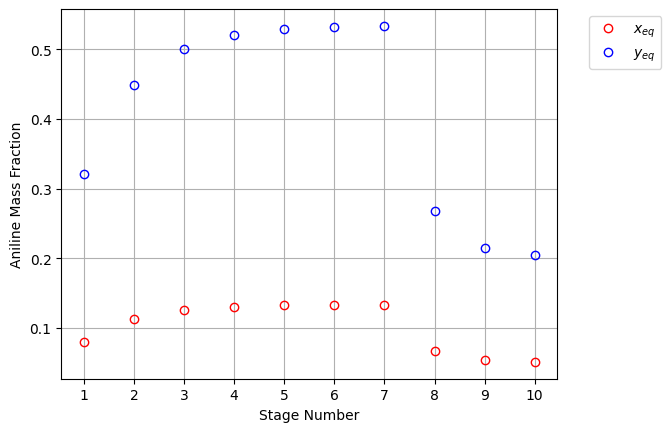

In [ ]:
n_etapas = np.linspace(1, N, N)
plt.plot(n_etapas, x_inv, 'ro', mfc='none', label=r'$x_{eq}$')
plt.plot(n_etapas, y_inv, 'bo', mfc='none', label=r'$y_{eq}$')
plt.legend(fontsize=10)
plt.grid()
plt.tick_params(labelsize=10)
plt.xticks(range(1, 11))
plt.xlabel('Stage Number')
plt.ylabel('Aniline Mass Fraction')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


### Gaussian Elimination Method

Now we solve the same problem using the Gaussian elimination method, which involves reducing matrix $A$ to a row-echelon form using elementary row operations, and then applying back substitution to find the values of $x$.

Types of elementary row operations:
- Swap two rows
- Multiply a row by a non-zero number
- Add a multiple of one row to another row, or subtract if the row is multiplied by -1

The Gaussian elimination algorithm:
1. Construct the augmented matrix $A^\star = [A|b]$
2. Select the first column from left to right.
3. If the first row of this column contains a zero, swap it with another row that does not (To improve stability, you can swap with the row containing the highest absolute value element).
4. Create zeros for all elements in the column below the element in the first row by adding suitable multiples of the first row to the rows below it.
5. Cover the top row.
6. Repeat the above process with the remaining submatrix.
7. Repeat steps 3 to 6 with the remaining rows. At the end of this step, the matrix will be in echelon form, and the augmented matrix will have been transformed to $[U|y]$.
8. Express the new system of equations, separating the augmented matrix to obtain $U x = y$
9. Apply back substitution to equation $n$, formed by multiplying row $n$ with the vector $x$ and setting it equal to $y_n$.
10. Apply back substitution to each upper row using the solution of $x_i$ to obtain $x_{i-1}$


In [ ]:
# Convert vector b to a column vector
b_col = b.reshape(-1, 1)

# Construct the augmented matrix
Aum = np.append(A, b_col, axis=1)


In [ ]:
# Gaussian Elimination Algorithm:
for i in range(0, N):  # Iterate through the matrix from column 0 to N-1
    pivot = np.abs(Aum[i][i])
    p_fila = i
    p_col = i

    # Check if any element in column i is non-zero
    if np.any(Aum[:, i]):
        # Find the row with the highest absolute value in column [j][i] for j > i
        for fila in range(i + 1, N):
            if np.abs(Aum[fila][i]) > pivot:
                pivot = np.abs(Aum[fila][i])
                p_fila = fila

        # Swap row i with row p_fila
        pf = np.eye(N)
        tmp = pf[i, :].copy()
        pf[i, :] = pf[p_fila, :]
        pf[p_fila, :] = tmp
        Aum = np.matmul(pf, Aum)

        # Eliminate elements below the diagonal element in column i
        b_fila = np.eye(N)
        for k in range(i + 1, N):
            b_fila[k, i] = -Aum[k, i] / Aum[i, i]
        Aum = np.matmul(b_fila, Aum)

# Perform back substitution
# Mass fractions of aniline in the aqueous stream
x_gaus = np.zeros(N)
x_gaus[N-1] = Aum[N-1, N] / Aum[N-1, N-1]
for i in range(N-2, -1, -1):
    tmp = np.sum(np.matmul(Aum[i, i+1:N], x_gaus[i+1:N]))
    x_gaus[i] = (Aum[i, N] - tmp) / Aum[i, i]

# Mass fractions of aniline in the extract
y_gaus = K * x_gaus


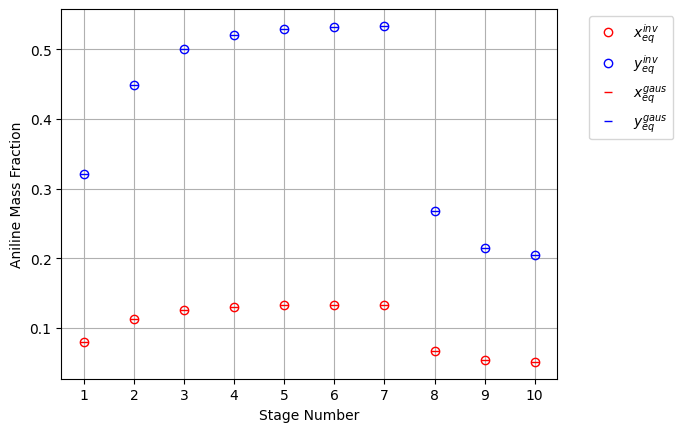

In [ ]:
# Plot both solutions
n_etapas = np.linspace(1, N, N)
plt.plot(n_etapas, x_inv, 'ro', mfc='none', label=r'$x_{eq}^{inv}$')
plt.plot(n_etapas, y_inv, 'bo', mfc='none', label=r'$y_{eq}^{inv}$')
plt.plot(n_etapas, x_gaus, 'r_', label=r'$x_{eq}^{gaus}$')
plt.plot(n_etapas, y_gaus, 'b_', label=r'$y_{eq}^{gaus}$')
plt.legend(fontsize=10)
plt.grid()
plt.tick_params(labelsize=10)
plt.xticks(range(1, 11))
plt.xlabel('Stage Number')
plt.ylabel('Aniline Mass Fraction')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


"""
### Gauss-Jordan Elimination Method for Tridiagonal Matrix Case

Now we solve the same problem using the Gauss-Jordan elimination method.

The Gauss-Jordan elimination method can be implemented using the Thomas algorithm in the special case of tridiagonal matrices with a dominant diagonal. This is where $|b_i | \geq |a_i |+|b_i |$ holds for a matrix A:


$\begin{bmatrix}
  \alpha_1 & \gamma_1 &  &&\\
  \beta_1 & \alpha_2 & \gamma_2 &  & \\
   & \cdot & \cdot & \cdot & \\
   &  & \cdot & \cdot & \gamma_{n-1}\\
   &  &  & \beta_{n-1} & \alpha_n
\end{bmatrix}\begin{bmatrix}
  x_1\\
  x_2\\
  x_3\\
  \vdots\\
  x_n
\end{bmatrix}{=}\begin{bmatrix}
  b_1\\
  b_2\\
  b_3\\
  \vdots\\
  b_n
\end{bmatrix}$

The Thomas algorithm consists of computing new coefficients, for i=1:

$\alpha_1^\ast {=} \alpha_1$\
$b_1^\ast {=} b_1$

while for $i=2, 3, \ldots, n$:

$m_i {=} \frac{\beta_{i-1}}{\alpha_{i-1}^\ast}$\
$\alpha_i^\ast {=} \alpha_i - m_i \gamma_{i-1}$\
$b_i^\ast = b_i - m_i b_{i-1}^\ast$

And then obtaining the solution of the vector x by back substitution, starting with $i=n$:

$x_n = \frac{b_n^\ast}{\alpha_n^\ast}$

and for $i = n-1, n-2,\ldots, 1$:

$x_i = \frac{b_i - \gamma_i x_{k+1}}{\alpha_k}$

In [ ]:
# Check if the tridiagonal matrix A is diagonally dominant

# Absolute values of the diagonal elements
D = np.diag(np.abs(A))

# Sum of the absolute values of the non-diagonal elements
S = np.sum(np.abs(A), axis=1) - D

if np.all(D >= S):
    print('The matrix A is diagonally dominant')
else:
    print('A is not diagonally dominant!')


The matrix A is diagonally dominant


In [ ]:
# Thomas Algorithm:
# Compute new coefficients
apr = np.zeros(N)
bpr = np.zeros(N)
apr[0] = A[0][0]
bpr[0] = b[0]
for i in range(1, N):
    m = A[i][i-1] / apr[i-1]
    apr[i] = A[i][i] - m * A[i-1][i]
    bpr[i] = b[i] - m * bpr[i-1]

# Perform back substitution
# Mass fractions of aniline in the aqueous stream
x_jord = np.zeros(N)
x_jord[N-1] = bpr[N-1] / apr[N-1]
for i in range(N-2, -1, -1):
    x_jord[i] = (b[i] - A[i-1][i] * x_jord[i+1]) / apr[i]

# Mass fractions of aniline in the extract
y_jord = K * x_jord


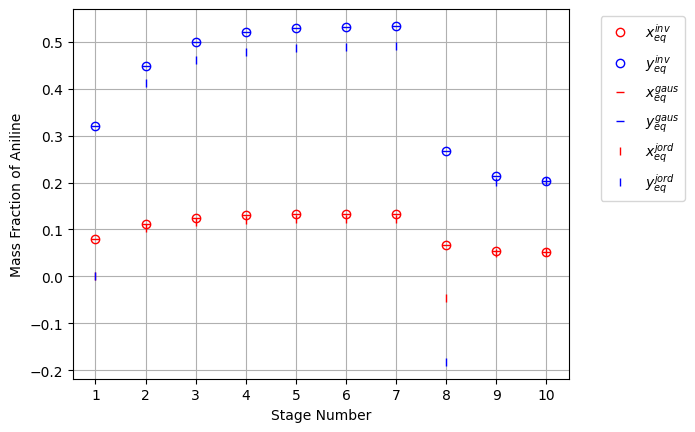

In [ ]:
# Plot the three solutions
n_etapas = np.linspace(1, N, N)
plt.plot(n_etapas, x_inv, 'ro', mfc='none', label=r'$x_{eq}^{inv}$')
plt.plot(n_etapas, y_inv, 'bo', mfc='none', label=r'$y_{eq}^{inv}$')
plt.plot(n_etapas, x_gaus, 'r_', label=r'$x_{eq}^{gaus}$')
plt.plot(n_etapas, y_gaus, 'b_', label=r'$y_{eq}^{gaus}$')
plt.plot(n_etapas, x_jord, 'r|', label=r'$x_{eq}^{jord}$')
plt.plot(n_etapas, y_jord, 'b|', label=r'$y_{eq}^{jord}$')
plt.legend(fontsize=10)
plt.grid()
plt.tick_params(labelsize=10)
plt.xticks(range(1, 11))
plt.xlabel('Stage Number')
plt.ylabel('Mass Fraction of Aniline')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#### Performance comparison

We will compare the computational time it takes for the algorithm to solve the system of equations. For this, we will write a function that is uniquely a function of the number of steps N

In [ ]:
def ell_algorithm(N, method='inversion'):
    # Build the matrix A
    A = np.zeros([N, N])

    # First row
    A[0][0] = -1 - K * (F_org / F_ac)
    A[0][1] = 1

    # Rows 2 to N-1

    # Start from 1 to skip the first row
    # Go up to N-1 to skip the last row
    for i in range(1, N-1):
        # First "moving column" of row i
        A[i][i-1] = K * (F_org / F_ac)

        # Second "moving column" of row i
        A[i][i] = -1 - K * (F_org / F_ac)

        # Third "moving column" of row i
        A[i][i+1] = 1

    # Last row
    A[N-1][N-2] = K * (F_org / F_ac)
    A[N-1][N-1] = -1 - K * (F_org / F_ac)

    # Build the vector b
    b = np.zeros(N)
    b[0] = -F_org / F_ac * y_e
    b[-1] = -x_e

    # Invert matrix and return the result
    if method == 'inversion':
        # Invert the matrix A
        A_inv = np.linalg.inv(A)
        # Mass fractions of aniline in the aqueous stream
        x = np.dot(A_inv, b)
    # Direct solution
    elif method == 'direct':
        x = np.linalg.solve(A, b)

    # Do some computation with x
    return x


In [ ]:
import timeit

# Number of iterations to test
n_it = 5000
N_list = np.logspace(1, 2, 10)

times = []

for N in N_list:
    # Start the timer
    start_time = timeit.default_timer()

    # Run the algorithm a fixed number of iterations
    for i in range(n_it):
        ell_algorithm(int(N), method='inversion')

    # Stop the timer
    end_time = timeit.default_timer()

    # Calculate the average computational time.
    inversion_ctime = (end_time - start_time) / n_it

    # Append the execution time
    times.append(inversion_ctime)

# Print or plot the results if needed
print("Average computational times:", times)


Average computational times: [0.00038090931740000544, 0.0002322760388000006, 0.00040585780260000775, 0.0003956658248000053, 0.0006305562577999922, 0.0008306146319999925, 0.001534861364599999, 0.0019188393356000006, 0.001692531424799995, 0.0019523487483999928]


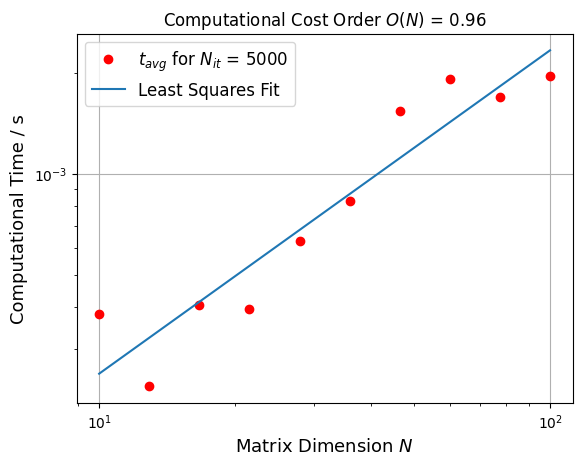

In [ ]:
# Create a figure and an axes object
fig, ax = plt.subplots()

# Set the x-axis and y-axis to logarithmic scale
ax.set_xscale("log")
ax.set_yscale("log")

# Plot the data on the axes object
ax.plot(N_list, times, 'ro', label='$t_{avg}$ for $N_{it}$ = %.0f' % n_it)

# Convert to logarithmic axes
log_N = np.log10(N_list)
log_time = np.log10(times)

# Fit a least squares line to the data points
m, b = np.polyfit(log_N, log_time, 1)

# Plot the least squares fit line
ax.plot(N_list, 10**(m*log_N + b), label='Least Squares Fit')

# Show the plot
plt.grid()
plt.xlabel("Matrix Dimension $N$", size=13)
plt.ylabel("Computational Time / s", size=13)
plt.legend(fontsize=12)
plt.title("Computational Cost Order $O(N)$ = %.2f" % m)
plt.show()